NEURAL NETWORK LIBRARY : It is a Framework allows you to build and train the neural networks.Neural networks made up of interconnected nodes which process data and learn to perform tasks like regression ,classification and prediction.

-->We have different components in neural network 
a)neuron-->receiving input and process it and gives the output .

b)LAYERS:: different layers are present used for performing computations  ,predictions 
   1)hidden layers , 2)output layers , 3)input layers.

c)Activation functions :: these are mostly used for performing complex problems .
-->basically these activation functions adds non linearity to the model.
-->some activations functions are sigmoid , rectified linear unit (reLu) , binary cross entropy loss.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

#here we defined class layer which is a base layer , this will create standard support for all the remaining layer which we are going to implement.
class Layer:
    def forward(self, input):
        raise NotImplementedError
    
    def backward(self, grad_output):
        raise NotImplementedError

#Linear Layer class performs the linear transformation on inputs by applying some weights and bias .
class Linear(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * np.sqrt(2.0 / input_size)
        self.bias = np.zeros(output_size)
    
    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias
    
    def backward(self, grad_output, learning_rate=0.01):
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(self.input.T, grad_output)
        grad_bias = np.sum(grad_output, axis=0)
        
        self.weights -= learning_rate * grad_weights
        self.bias -= learning_rate * grad_bias
        
        return grad_input

#here we defined sigmoid class which we call it as activation function.this function basically used in binary classification .
#sigmoid takes the input and gives teh output value as 0 or 1 (yes/no).
class Sigmoid(Layer):
    def forward(self, input):
        self.output = 1 / (1 + np.exp(-input))
        return self.output
    
    def backward(self, grad_output):
        sigmoid_grad = self.output * (1 - self.output)
        return grad_output * sigmoid_grad

# Tanh activation function
class Tanh(Layer):
    def forward(self, input):
        self.output = np.tanh(input)
        return self.output
    
    def backward(self, grad_output):
        return grad_output * (1 - self.output ** 2)

# Binary Cross-Entropy Loss layer calculates the loss based on the ouput probabilities .
class BinaryCrossEntropyLoss:
    def forward(self, predictions, targets):
        self.predictions = predictions
        self.targets = targets
        epsilon = 1e-12
        predictions = np.clip(predictions, epsilon, 1. - epsilon)
        return -np.mean(targets * np.log(predictions) + (1 - targets) * np.log(1 - predictions))
    
    def backward(self):
        return (self.predictions - self.targets) / (self.predictions * (1 - self.predictions) * self.targets.shape[0])

#Sequential class helps to add layers in a correct order or in a sequential order.
class Sequential:
    def __init__(self):
        self.layers = []
    
    def add(self, layer):
        self.layers.append(layer)
    
    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input
    
    def backward(self, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
    
    def save_weights(self, filename):
        weights = {f"layer_{i}_weights": layer.weights for i, layer in enumerate(self.layers) if hasattr(layer, 'weights')}
        biases = {f"layer_{i}_biases": layer.bias for i, layer in enumerate(self.layers) if hasattr(layer, 'bias')}
        
        np.savez(filename, **weights, **biases)
    
    def load_weights(self, filename):
        data = np.load(filename)
        for i, layer in enumerate(self.layers):
            if hasattr(layer, 'weights'):
                layer.weights = data[f"layer_{i}_weights"]
            if hasattr(layer, 'bias'):
                layer.bias = data[f"layer_{i}_biases"]

# XOR 
def solve_xor(activation='sigmoid'):
#we are using the inputs and ouputs here to solve xor problem. we took sample inputs to see the output .so,here for every two inputs you get one output .
#xor is a exclusive OR . Xor is just a binary classification but here it creates the non linear relationship .so it needs neural network to with layers to learn .
    X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    y_xor = np.array([[0], [1], [1], [0]])  

    model = Sequential()  #we construct the model here
    model.add(Linear(2, 2))
    
    if activation == 'sigmoid':
        model.add(Sigmoid())
    elif activation == 'tanh':
        model.add(Tanh())
    
    model.add(Linear(2, 1))
    model.add(Sigmoid())

    loss_fn = BinaryCrossEntropyLoss()  #we add the loss function here 
# Training  the model with learning rate and steps .
    learning_rate = 0.1
    epochs = 10000
    losses = []    # Store losses for plotting

    for epoch in range(epochs):
        predictions = model.forward(X_xor)
        loss = loss_fn.forward(predictions, y_xor)
        losses.append(loss)   # Store loss for plotting

        grad_loss = loss_fn.backward()
        model.backward(grad_loss)

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}: Loss = {loss}")

    model.save_weights(f"XOR_solved_{activation}.npz")

    plot_loss(losses, activation) #plotting the loss
    plot_decision_boundary(model, X_xor, y_xor, activation)  #decision  boundary plotting

    return predictions

 # here we create a Function to plot loss over epochs.
def plot_loss(losses, activation):
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title(f'Loss over Epochs for XOR Problem with {activation.capitalize()} Activation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

# we define Function to plot the decision boundary.
def plot_decision_boundary(model, X_xor, y_xor, activation):
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]

    grid_predictions = model.forward(grid)
    grid_predictions = np.round(grid_predictions).reshape(xx.shape)
    plt.figure(figsize=(10, 5))
    plt.contourf(xx, yy, grid_predictions, alpha=0.6, levels=[0, 0.5, 1], colors=['orange', 'green'])
    scatter_colors = ['green' if label == 0 else 'orange' for label in y_xor.flatten()]
    plt.scatter(X_xor[:, 0], X_xor[:, 1], c=scatter_colors, edgecolors='k', marker='o', s=100)
    
    plt.title(f'Decision Boundary for XOR Problem with {activation.capitalize()} Activation')
    plt.xlabel('Input 1')
    plt.ylabel('Input 2')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid()
    plt.show()

Epoch 0: Loss = 0.8603900619377424
Epoch 1000: Loss = 0.5572829907505794
Epoch 2000: Loss = 0.486850527605146
Epoch 3000: Loss = 0.44712824636774373
Epoch 4000: Loss = 0.42138898326998053
Epoch 5000: Loss = 0.4037315372337221
Epoch 6000: Loss = 0.391512183571875
Epoch 7000: Loss = 0.3829382253534396
Epoch 8000: Loss = 0.37677313774431315
Epoch 9000: Loss = 0.3722127761169671


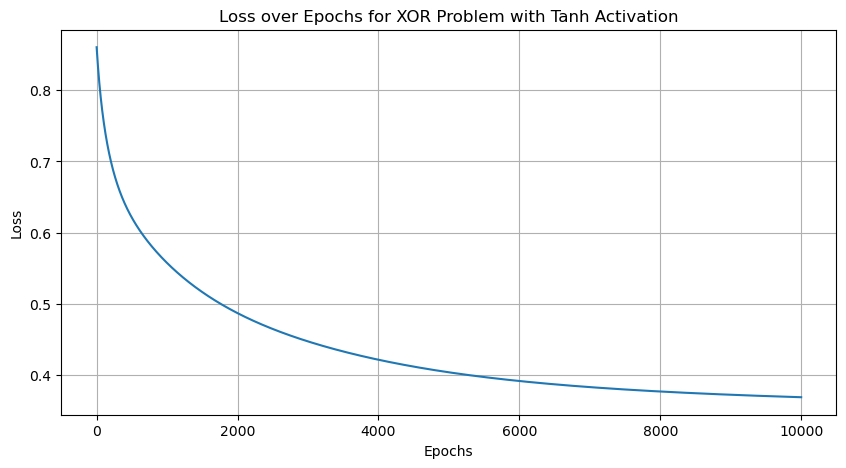

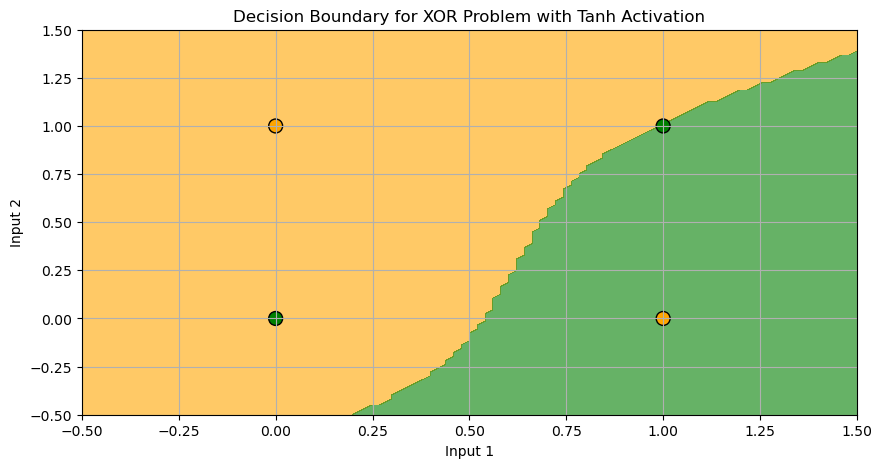

In [2]:
# Solve XOR with Tanh activation
xor_predictions_tanh = solve_xor(activation='tanh')


Epoch 0: Loss = 0.71298803268496
Epoch 1000: Loss = 0.7039058742037991
Epoch 2000: Loss = 0.7004425217602263
Epoch 3000: Loss = 0.6981349830579759
Epoch 4000: Loss = 0.6965785896175096
Epoch 5000: Loss = 0.6955114764947372
Epoch 6000: Loss = 0.6947643176323756
Epoch 7000: Loss = 0.694227655876628
Epoch 8000: Loss = 0.6938303897355231
Epoch 9000: Loss = 0.6935258235926722


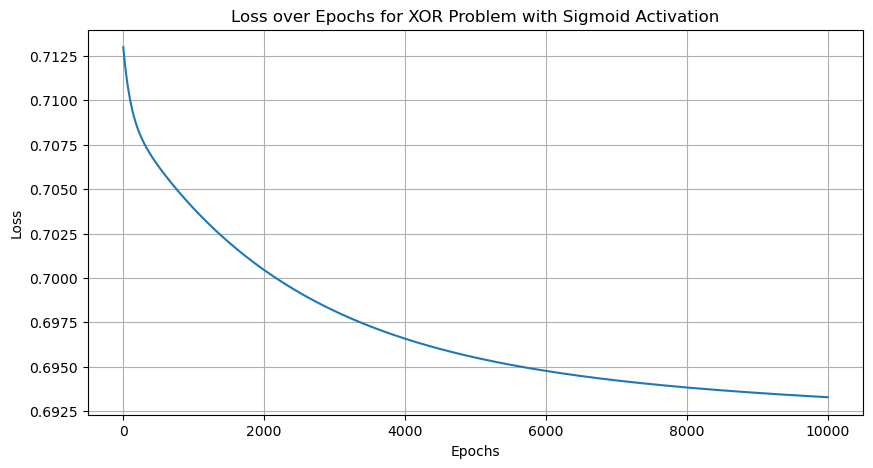

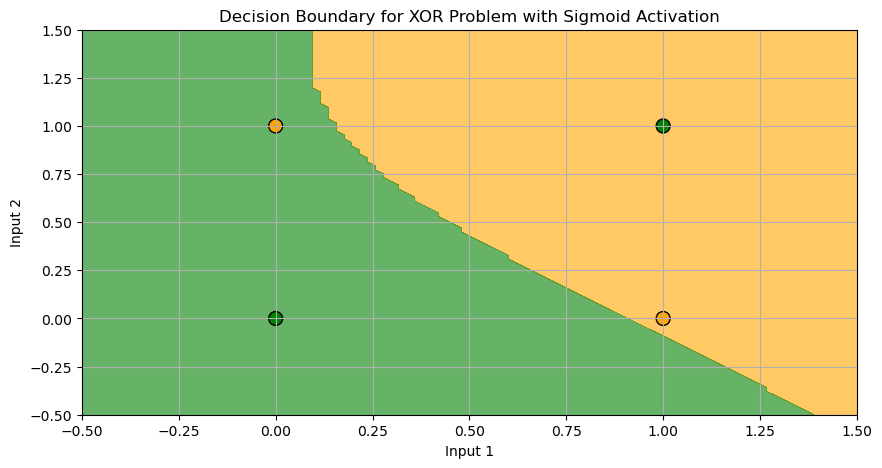

In [3]:
# Solve XOR with Sigmoid activation
xor_predictions_sigmoid = solve_xor(activation='sigmoid')

In [4]:
xor_predictions_tanh, xor_predictions_sigmoid

(array([[0.03644728],
        [0.48414471],
        [0.98202157],
        [0.50060117]]),
 array([[0.51607621],
        [0.50281636],
        [0.49835838],
        [0.48487102]]))

In [5]:
import numpy as np
dataset = np.load(r"C:\Users\DELL\Downloads\nyc_taxi_data.npy", allow_pickle=True).item()

X_train, y_train, X_test, y_test = dataset["X_train"], dataset["y_train"], dataset["X_test"], dataset["y_test"]

In [6]:
X_train, y_train, X_test, y_test

(                id  vendor_id      pickup_datetime     dropoff_datetime  \
 879655   id2425795          1  2016-01-08 23:55:11  2016-01-09 00:04:32   
 646838   id0767831          2  2016-03-05 09:52:06  2016-03-05 10:00:12   
 1138713  id0449104          1  2016-04-09 16:03:53  2016-04-09 16:21:22   
 864716   id3030157          1  2016-01-06 11:12:44  2016-01-06 11:19:49   
 434927   id1584885          1  2016-06-26 09:10:56  2016-06-26 09:17:44   
 ...            ...        ...                  ...                  ...   
 259178   id1753868          2  2016-03-25 07:11:49  2016-03-25 07:33:10   
 1414414  id2204747          1  2016-02-16 18:01:45  2016-02-16 18:15:38   
 131932   id3043606          2  2016-01-26 19:22:29  2016-01-26 19:43:54   
 671155   id1458584          1  2016-01-19 11:53:47  2016-01-19 12:00:16   
 121958   id0357025          2  2016-02-10 22:39:31  2016-02-10 23:05:41   
 
          passenger_count  pickup_longitude  pickup_latitude  \
 879655               

In [7]:
print(dataset.keys()) 

dict_keys(['X_train', 'X_test', 'y_train', 'y_test'])


In [8]:
import pandas as pd 
X_train = pd.DataFrame(dataset["X_train"])
y_train = pd.Series(dataset["y_train"])  # if it's a 1D array
print(X_train.columns)

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag'],
      dtype='object')


In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df = dataset['X_train'] 

# here we are Converting  datetime columns to datetime object to perform some taks easily 
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

df['hour_of_day'] = df['pickup_datetime'].dt.hour #we are extracting the hour of day and day of week for further analysis .
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek

df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() #trip duration in seconds 

# Calculating Euclidean distance 
df['distance'] = np.sqrt(
    (df['pickup_latitude'] - df['dropoff_latitude'])**2 +
    (df['pickup_longitude'] - df['dropoff_longitude'])**2
)

# by applying the log transformation to trip duration it handles the outliers and reduces the skewness.
df['log_trip_duration'] = np.log1p(df['trip_duration'])

# One-hot encoding for vendor_id and store_and_fwd_flag
df = pd.get_dummies(df, columns=['vendor_id', 'store_and_fwd_flag'], drop_first=True)

#we are doing normalization here beacuse for every feature we have different ranges which makes the model inperfect .by using the normalization techniques it changes all features to standard ranges.
#we used min max scaleer technique to scale the eveery feature into specific range .
features_to_scale = ['passenger_count', 'hour_of_day', 'day_of_week', 'distance', 'log_trip_duration']
scaler = MinMaxScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

df['hour_passenger_interaction'] = df['hour_of_day'] * df['passenger_count']

bins = [0, 600, 1200, np.inf] #bins defining
labels = ['short', 'medium', 'long']
df['trip_duration_bin'] = pd.cut(df['trip_duration'], bins=bins, labels=labels)

df.drop(columns=['pickup_datetime', 'dropoff_datetime', 'trip_duration'], inplace=True) #unused columns are dropped here.

print(df.head())


                id  passenger_count  pickup_longitude  pickup_latitude  \
879655   id2425795         0.111111        -73.955551        40.773346   
646838   id0767831         0.111111        -73.962181        40.763599   
1138713  id0449104         0.111111        -73.977486        40.751842   
864716   id3030157         0.111111        -73.970001        40.762363   
434927   id1584885         0.111111        -73.950348        40.771561   

         dropoff_longitude  dropoff_latitude  hour_of_day  day_of_week  \
879655          -73.973640         40.763500     1.000000     0.666667   
646838          -73.980377         40.764919     0.391304     0.833333   
1138713         -74.011688         40.718925     0.695652     0.833333   
864716          -73.963264         40.774666     0.478261     0.333333   
434927          -73.968178         40.762409     0.391304     1.000000   

         distance  log_trip_duration  vendor_id_2  store_and_fwd_flag_Y  \
879655   0.001840           0.39202

In [10]:
print(df.keys())

Index(['id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'hour_of_day', 'day_of_week',
       'distance', 'log_trip_duration', 'vendor_id_2', 'store_and_fwd_flag_Y',
       'hour_passenger_interaction', 'trip_duration_bin'],
      dtype='object')


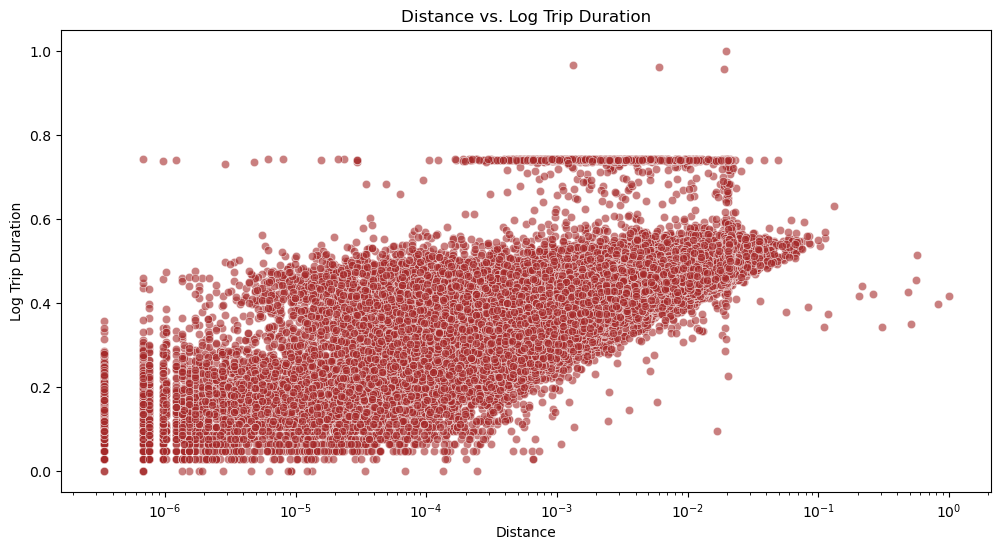

In [11]:
import seaborn as sns 
# Scatter plot of distance vs. log trip duration
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='distance', y='log_trip_duration',color='brown', alpha=0.6)
plt.title('Distance vs. Log Trip Duration')
plt.xlabel('Distance')
plt.ylabel('Log Trip Duration')
plt.xscale('log') 
plt.show()


C:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


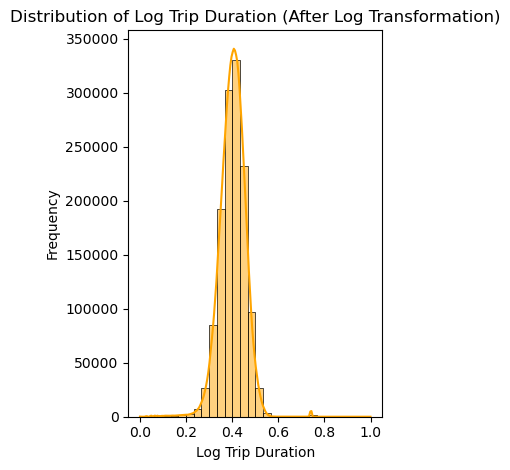

In [12]:
import seaborn as sns
#we are plotting the trip duration after applying the log transformation.
plt.subplot(1, 2, 2)
sns.histplot(df['log_trip_duration'], bins=30, kde=True, color='orange')
plt.title('Distribution of Log Trip Duration (After Log Transformation)')
plt.xlabel('Log Trip Duration')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Unique values in 'vendor_id_2': [False  True]


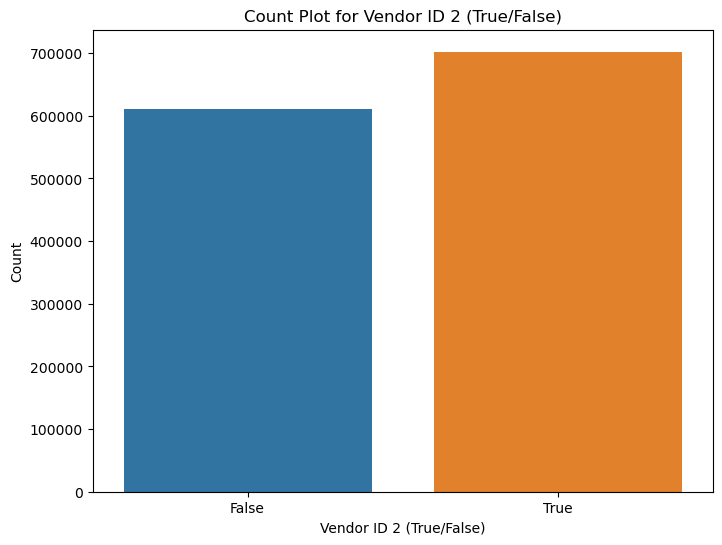

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
print("Unique values in 'vendor_id_2':", df['vendor_id_2'].unique())
plt.figure(figsize=(8, 6))
sns.countplot(x='vendor_id_2', data=df)
plt.title('Count Plot for Vendor ID 2 (True/False)')
plt.xlabel('Vendor ID 2 (True/False)')
plt.ylabel('Count')
plt.show()


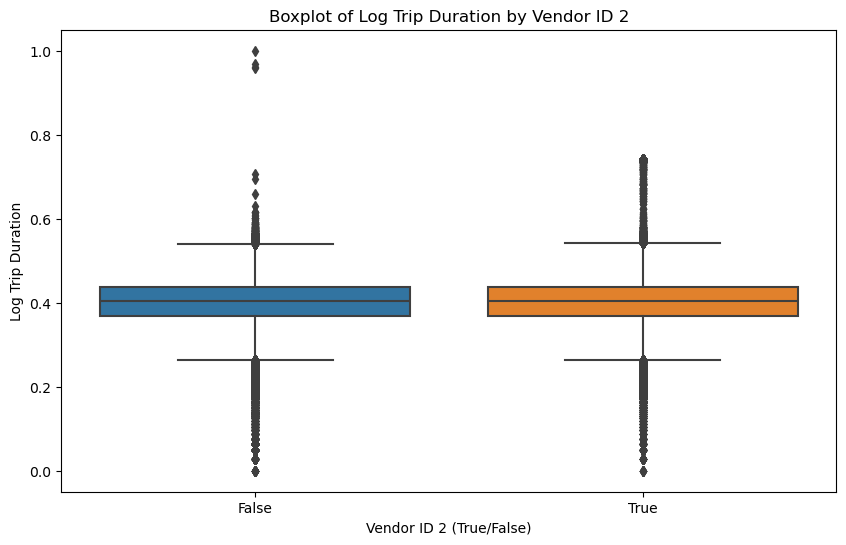

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='vendor_id_2', y='log_trip_duration', data=df)
plt.title('Boxplot of Log Trip Duration by Vendor ID 2')
plt.xlabel('Vendor ID 2 (True/False)')
plt.ylabel('Log Trip Duration')
plt.show()


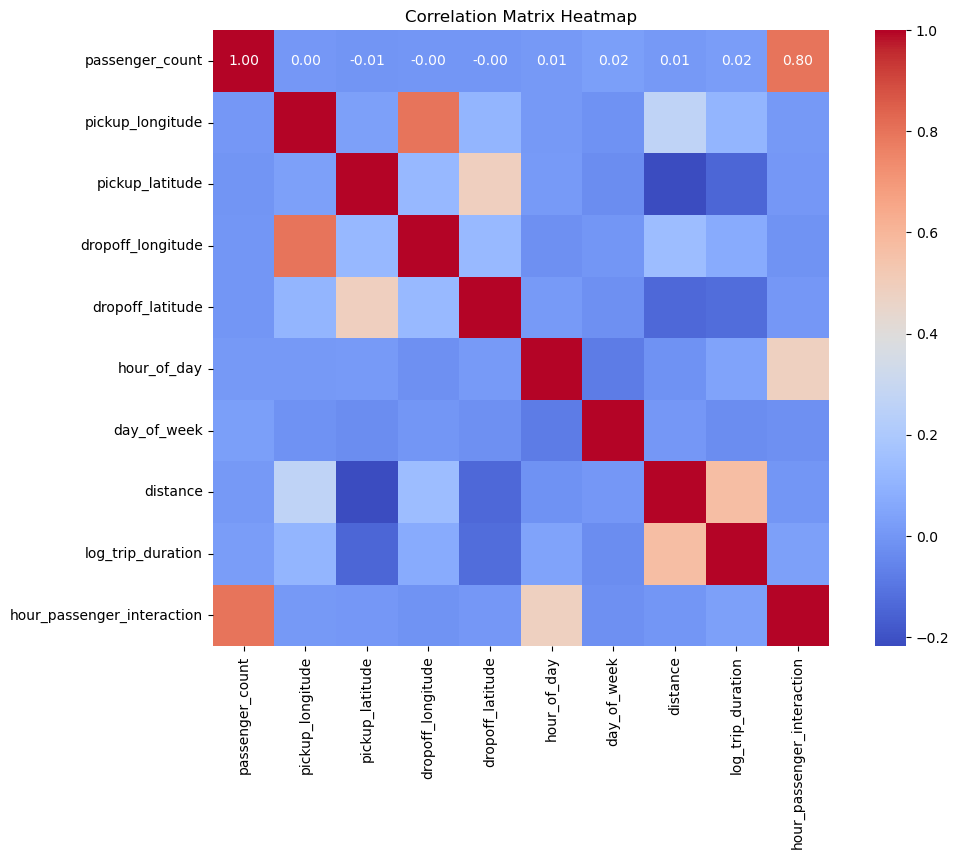

In [15]:
#  numerical columns for correlation
numerical_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [16]:
import pandas as pd

X = df.drop(columns=['trip_duration_bin'])  
y = df['trip_duration_bin']  #target variable.

# Converting boolean columns to integers
X['vendor_id_2'] = X['vendor_id_2'].astype(int)
X['store_and_fwd_flag_Y'] = X['store_and_fwd_flag_Y'].astype(int)

# Converting categorical target variable to numeric
if pd.api.types.is_categorical_dtype(y):
    y = y.cat.codes  

y = y.astype(float)
print("Data types after conversion:")
print(X.dtypes)
print("Data type of target variable (y):", y.dtype)


Data types after conversion:
id                             object
passenger_count               float64
pickup_longitude              float64
pickup_latitude               float64
dropoff_longitude             float64
dropoff_latitude              float64
hour_of_day                   float64
day_of_week                   float64
distance                      float64
log_trip_duration             float64
vendor_id_2                     int32
store_and_fwd_flag_Y            int32
hour_passenger_interaction    float64
dtype: object
Data type of target variable (y): float64


C:\Users\DELL\AppData\Local\Temp\ipykernel_6292\3594917031.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):


In [17]:
#checking data types before conversion and checking the object type of it .
print("Data types before conversion:")
print(X.dtypes)
object_columns = X.select_dtypes(include=['object']).columns
print("Object columns:", object_columns)


Data types before conversion:
id                             object
passenger_count               float64
pickup_longitude              float64
pickup_latitude               float64
dropoff_longitude             float64
dropoff_latitude              float64
hour_of_day                   float64
day_of_week                   float64
distance                      float64
log_trip_duration             float64
vendor_id_2                     int32
store_and_fwd_flag_Y            int32
hour_passenger_interaction    float64
dtype: object
Object columns: Index(['id'], dtype='object')


In [18]:
import pandas as pd

object_columns = X.select_dtypes(include='object').columns
unique_counts = X[object_columns].nunique()
print(unique_counts)

threshold = 100
for col in object_columns:
    if X[col].nunique() > threshold:
        freq = X[col].value_counts()
        X[col] = X[col].where(X[col].isin(freq[freq >= 10].index), 'Other')

relevant_object_columns = [col for col in object_columns if col in X.columns and X[col].nunique() < threshold] #converting relevant columns to dummies.
X = pd.get_dummies(X, columns=relevant_object_columns, drop_first=True, sparse=True)


id    1312779
dtype: int64


In [19]:
#we see different types of object types so we are converting all columns to float values.
X = X.astype(float)
print("Data types after conversion:")
print(X.dtypes)


Data types after conversion:
passenger_count               float64
pickup_longitude              float64
pickup_latitude               float64
dropoff_longitude             float64
dropoff_latitude              float64
hour_of_day                   float64
day_of_week                   float64
distance                      float64
log_trip_duration             float64
vendor_id_2                   float64
store_and_fwd_flag_Y          float64
hour_passenger_interaction    float64
dtype: object


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#printing original dataframe first 
print("Original DataFrame shape:", df.shape)
print("Original DataFrame columns:", df.columns)
print("\nOriginal DataFrame data:")
print(df.head())
y = df['trip_duration_bin'] #target variable.

X = df.drop(columns=['trip_duration_bin', 'id'], errors='ignore') #features variable and target variable.

X = X.dropna() #NaN values are dropped .
y = y[X.index] 
print("Updated X shape:", X.shape)
print("Updated y shape:", y.shape)

# we are dividing the dataset into trainig ,validation and testing.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# shapes after dividing
print("Shapes after split:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Normalizing features here 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Scaled training data:")
print(X_train_scaled[:5])  # Display the first 5 rows of scaled data


Original DataFrame shape: (1312779, 14)
Original DataFrame columns: Index(['id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'hour_of_day', 'day_of_week',
       'distance', 'log_trip_duration', 'vendor_id_2', 'store_and_fwd_flag_Y',
       'hour_passenger_interaction', 'trip_duration_bin'],
      dtype='object')

Original DataFrame data:
                id  passenger_count  pickup_longitude  pickup_latitude  \
879655   id2425795         0.111111        -73.955551        40.773346   
646838   id0767831         0.111111        -73.962181        40.763599   
1138713  id0449104         0.111111        -73.977486        40.751842   
864716   id3030157         0.111111        -73.970001        40.762363   
434927   id1584885         0.111111        -73.950348        40.771561   

         dropoff_longitude  dropoff_latitude  hour_of_day  day_of_week  \
879655          -73.973640         40.763500     1.000000     0.666667   
6468

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_log_error
import time

X = df.drop(columns=['id', 'trip_duration_bin'])  # Drop unnecessary columns and assign feature varibale and target variable.
y = df['trip_duration_bin']

X['vendor_id_2'] = X['vendor_id_2'].astype(int)  # Converting boolean to int
X['store_and_fwd_flag_Y'] = X['store_and_fwd_flag_Y'].astype(int)  # Converting boolean to int

#dropping Nan values here .
X.dropna(inplace=True)
y = y[X.index] 

# Converting categorical target variable to numeric
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#we are dividing the dataset into trainig ,testing and validation.
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) 

# Scaling the features to keep specific ranges .
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)  # Scale the test data as well

#we are doing three different models to find the accuracy how well the predicted values are showing significant with actaul values .
model1 = keras.Sequential([
    layers.Input(shape=X_train_scaled.shape[1:]),
    layers.Dense(32, activation='relu'),  
    layers.Dense(len(label_encoder.classes_), activation='softmax')  
])

# Compiling  the model1.
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
start_time = time.time()
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)  

# Training  the model1  with assigning the epochs = 6 
model1_accuracy = model1.fit(X_train_scaled, y_train, 
                    validation_data=(X_val_scaled, y_val), 
                    epochs=6,  # Reduced epochs for faster training
                    batch_size=64,  # Increased batch size
                    callbacks=[early_stopping],
                    verbose=1)  # Show training progress

test_loss, test_accuracy = model1.evaluate(X_test_scaled, y_test, verbose=0) #we evaluate the loss on test data 
print(f'Test Accuracy: {test_accuracy:.4f}')

#RMSLE->root mean square logarithmic error .
def calculate_rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

#predictions on test dataset .
y_pred_probs = model1.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Calculating RMSLE
rmsle = calculate_rmsle(y_test, y_pred_classes)
print(f'RMSLE: {rmsle:.4f}')
end_time = time.time()
execution_time = end_time - start_time
print(f'Execution Time: {execution_time:.2f} seconds')


Epoch 1/6
14359/14359 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - accuracy: 0.9345 - loss: 0.1878 - val_accuracy: 0.9972 - val_loss: 0.0188
Epoch 2/6
14359/14359 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - accuracy: 0.9965 - loss: 0.0171 - val_accuracy: 0.9971 - val_loss: 0.0141
Epoch 3/6
14359/14359 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - accuracy: 0.9970 - loss: 0.0117 - val_accuracy: 0.9979 - val_loss: 0.0105
Epoch 4/6
14359/14359 ━━━━━━━━━━━━━━━━━━━━ 52s 4ms/step - accuracy: 0.9973 - loss: 0.0092 - val_accuracy: 0.9977 - val_loss: 0.0089
Epoch 5/6
14359/14359 ━━━━━━━━━━━━━━━━━━━━ 53s 4ms/step - accuracy: 0.9976 - loss: 0.0083 - val_accuracy: 0.9969 - val_loss: 0.0097
Epoch 6/6
14359/14359 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - accuracy: 0.9977 - loss: 0.0077 - val_accuracy: 0.9980 - val_loss: 0.0094
Test Accuracy: 0.9976
6154/6154 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
RMSLE: 0.0288
Execution Time: 366.83 seconds


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_log_error
import time

print("Initial DataFrame shape:", df.shape) #printing intial dataframe
X = df.drop(columns=['id', 'trip_duration_bin'])  # Drop unnecessary columns and adding feature variables
y = df['trip_duration_bin'] #assigning target variable

X['vendor_id_2'] = X['vendor_id_2'].astype(int)  # Converting boolean to integer
X['store_and_fwd_flag_Y'] = X['store_and_fwd_flag_Y'].astype(int)  # Converting boolean to integer

X.dropna(inplace=True) #dropping Nan values 
y = y[X.index] 

# Converting categorical target variable to numeric
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# we are dividing the dataset into training, validation, and test sets.
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 50% of temp for test

# Scaling the features to keep specific range
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)  # Scaling the test data here

start_time_model2 = time.time()
#we are modelling here by adding some more complex values by increasing the neurons and adding more hidden layers 
model2 = keras.Sequential([
    layers.Input(shape=X_train_scaled.shape[1:]),
    layers.Dense(64, activation='relu'),  
    layers.Dense(32, activation='relu'),  
    layers.Dense(16, activation='relu'),  
    layers.Dense(len(label_encoder.classes_), activation='softmax') 
])

# Compiling the model2
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping_model2 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model2 with epochs 10 
model2_accuracy = model2.fit(X_train_scaled, y_train, 
                             validation_data=(X_val_scaled, y_val), 
                             epochs=10,  
                             batch_size=32, 
                             callbacks=[early_stopping_model2],
                             verbose=1) 

test_loss_model2, test_accuracy_model2 = model2.evaluate(X_test_scaled, y_test, verbose=0) #evaluating the loss for model2
print(f'Model 2 Test Accuracy: {test_accuracy_model2:.4f}')
#RMSLE--> root mean square logarthimic error.
def calculate_rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
    
y_pred_probs_model2 = model2.predict(X_test_scaled)
y_pred_classes_model2 = np.argmax(y_pred_probs_model2, axis=1)

# Calculating RMSLE
rmsle_model2 = calculate_rmsle(y_test, y_pred_classes_model2)
print(f'Model 2 RMSLE: {rmsle_model2:.4f}')
end_time_model2 = time.time()
execution_time_model2 = end_time_model2 - start_time_model2
print(f'Model 2 Execution Time: {execution_time_model2:.2f} seconds')


Initial DataFrame shape: (1312779, 14)
Epoch 1/10
28718/28718 ━━━━━━━━━━━━━━━━━━━━ 91s 3ms/step - accuracy: 0.9752 - loss: 0.0634 - val_accuracy: 0.9940 - val_loss: 0.0142
Epoch 2/10
28718/28718 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step - accuracy: 0.9927 - loss: 0.0174 - val_accuracy: 0.9946 - val_loss: 0.0130
Epoch 3/10
28718/28718 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step - accuracy: 0.9942 - loss: 0.0149 - val_accuracy: 0.9923 - val_loss: 0.0181
Epoch 4/10
28718/28718 ━━━━━━━━━━━━━━━━━━━━ 74s 3ms/step - accuracy: 0.9950 - loss: 0.0117 - val_accuracy: 0.9962 - val_loss: 0.0097
Epoch 5/10
28718/28718 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step - accuracy: 0.9955 - loss: 0.0107 - val_accuracy: 0.9968 - val_loss: 0.0125
Epoch 6/10
28718/28718 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - accuracy: 0.9959 - loss: 0.0122 - val_accuracy: 0.9954 - val_loss: 0.0129
Epoch 7/10
28718/28718 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.9963 - loss: 0.0100 - val_accuracy: 0.9958 - val_loss: 0.0129
Model 2 Test Accuracy: 0.9959


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_log_error
import time
X = df.drop(columns=['id', 'trip_duration_bin'])  # Drop unnecessary columns and assign feature variable and target variable
y = df['trip_duration_bin'] #target variable.

X['vendor_id_2'] = X['vendor_id_2'].astype(int)  # Converting boolean  to int
X['store_and_fwd_flag_Y'] = X['store_and_fwd_flag_Y'].astype(int)  # Converting boolean to int

X.dropna(inplace=True) #dropping Nan values
y = y[X.index] 

# Converting categorical target variable to numeric.
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# we are dividing  the dataset into training, validation, and test sets.
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 50% of temp for test

# Scaling the features to keep the specific range to each feature
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)  # Scaling the test data.
start_time_model3 = time.time()

#we are defining model3 with hidden layers and droupout layers
model3 = keras.Sequential([
    layers.Input(shape=X_train_scaled.shape[1:]),
    layers.Dense(64, activation='relu'),  
    layers.Dropout(0.5),  
    layers.Dense(32, activation='relu'), 
    layers.Dropout(0.5),
    layers.Dense(16, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax') 
])

# Compiling the model3
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping_model3 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 

# Training the model with epochs 7
model3_accuracy = model3.fit(X_train_scaled, y_train, 
                             validation_data=(X_val_scaled, y_val), 
                             epochs=7,  # Adjusted epochs for experimentation
                             batch_size=32,  # Adjusted batch size
                             callbacks=[early_stopping_model3],
                             verbose=1)  # Show training progress

test_loss_model3, test_accuracy_model3 = model3.evaluate(X_test_scaled, y_test, verbose=0) #evaluating loss on test data 
print(f'Model 3 Test Accuracy: {test_accuracy_model3:.4f}')

#RMSLE-->root mean square logarthimic error 
def calculate_rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

y_pred_probs_model3 = model3.predict(X_test_scaled)
y_pred_classes_model3 = np.argmax(y_pred_probs_model3, axis=1)

# Calculating RMSLE
rmsle_model3 = calculate_rmsle(y_test, y_pred_classes_model3)
print(f'Model 3 RMSLE: {rmsle_model3:.4f}')
end_time_model3 = time.time()
execution_time_model3 = end_time_model3 - start_time_model3
print(f'Model 3 Execution Time: {execution_time_model3:.2f} seconds')


Epoch 1/7
28718/28718 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - accuracy: 0.9394 - loss: 0.1411 - val_accuracy: 0.9911 - val_loss: 0.0198
Epoch 2/7
28718/28718 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step - accuracy: 0.9904 - loss: 0.0239 - val_accuracy: 0.9903 - val_loss: 0.0228
Epoch 3/7
28718/28718 ━━━━━━━━━━━━━━━━━━━━ 60s 2ms/step - accuracy: 0.9920 - loss: 0.0217 - val_accuracy: 0.9917 - val_loss: 0.0182
Epoch 4/7
28718/28718 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - accuracy: 0.9923 - loss: 0.0196 - val_accuracy: 0.9914 - val_loss: 0.0187
Epoch 5/7
28718/28718 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - accuracy: 0.9933 - loss: 0.0180 - val_accuracy: 0.9949 - val_loss: 0.0129
Epoch 6/7
28718/28718 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step - accuracy: 0.9935 - loss: 0.0223 - val_accuracy: 0.9953 - val_loss: 0.0117
Epoch 7/7
28718/28718 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - accuracy: 0.9939 - loss: 0.0163 - val_accuracy: 0.9930 - val_loss: 0.0160
Model 3 Test Accuracy: 0.9952
6154/6154 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
Mod

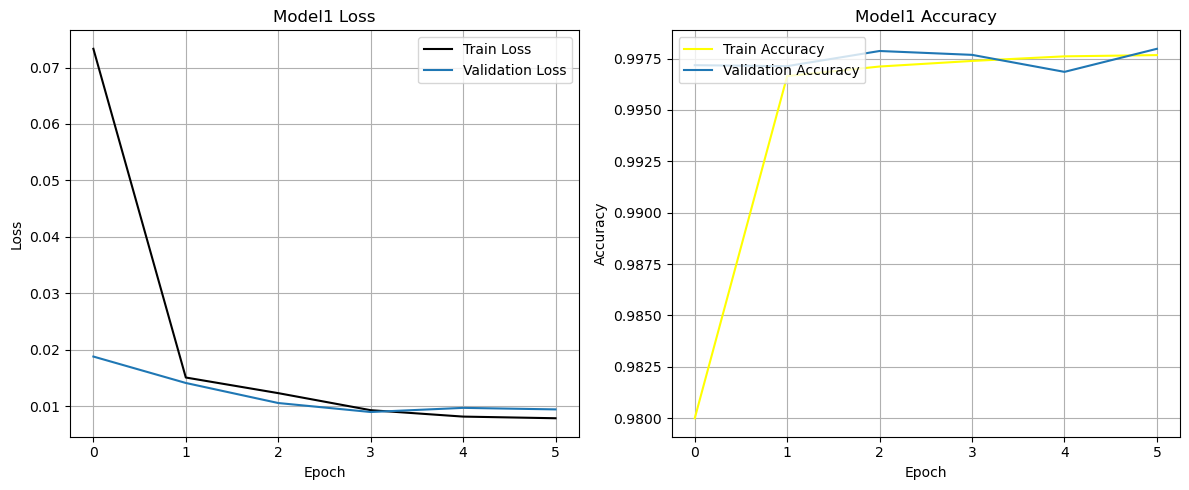

In [24]:
# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(model1_accuracy.history['loss'],color='black', label='Train Loss')
plt.plot(model1_accuracy.history['val_loss'], label='Validation Loss')
plt.title('Model1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(model1_accuracy.history['accuracy'],color='yellow', label='Train Accuracy')
plt.plot(model1_accuracy.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model1 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()


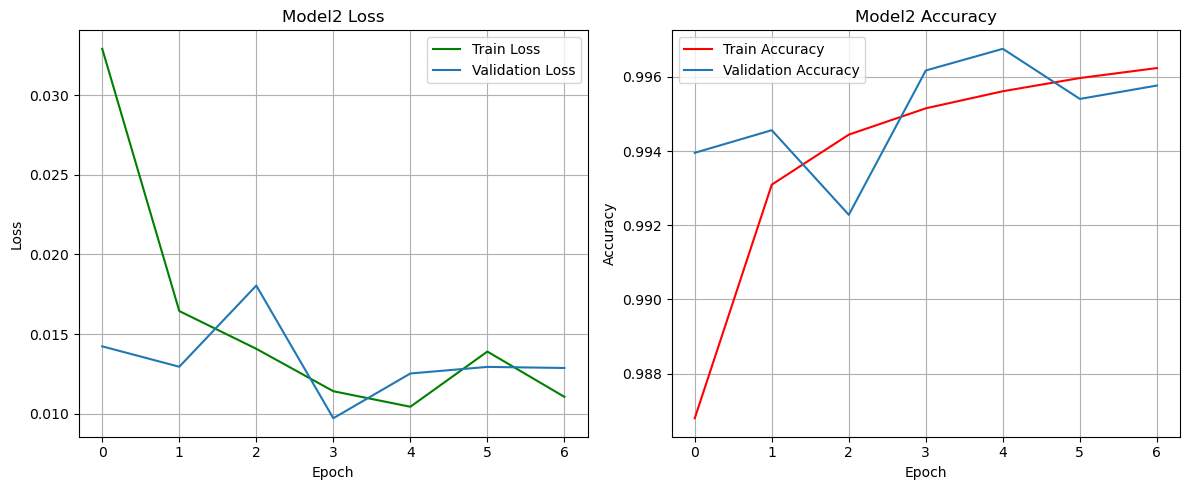

In [25]:
# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(model2_accuracy.history['loss'],color='green', label='Train Loss')
plt.plot(model2_accuracy.history['val_loss'], label='Validation Loss')
plt.title('Model2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(model2_accuracy.history['accuracy'],color='red', label='Train Accuracy')
plt.plot(model2_accuracy.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()


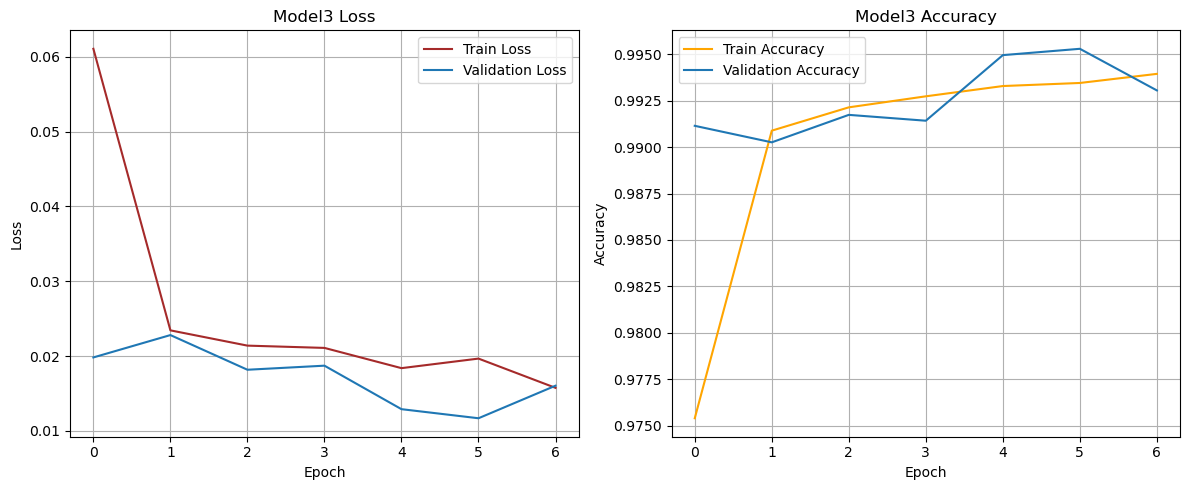

In [26]:
# Plot training & validation loss values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(model3_accuracy.history['loss'],color='brown', label='Train Loss')
plt.plot(model3_accuracy.history['val_loss'], label='Validation Loss')
plt.title('Model3 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(model3_accuracy.history['accuracy'],color='orange', label='Train Accuracy')
plt.plot(model3_accuracy.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()
